In [1]:
import pandas as pd
import numpy as np

import yfinance
import ta
from ta.momentum import ROCIndicator, StochasticOscillator, RSIIndicator
from ta.trend import CCIIndicator, EMAIndicator, TRIXIndicator, macd
from ta.volume import OnBalanceVolumeIndicator, VolumeWeightedAveragePrice, force_index, ChaikinMoneyFlowIndicator, MFIIndicator
from ta.volatility import BollingerBands

import keras_tuner as kt

2023-04-13 21:37:14.224721: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# df = pd.read_csv('bitcoin_df.csv')
# del df['Unnamed: 0']  

In [7]:
def get_rename_dict(df, name):
  rename_dict = {'Date':'date'}
  for e in df.columns[1:]:
      rename_dict[e] = name+'_'+e.lower()
  return rename_dict
btc_df = pd.read_csv('BTC-USD.csv')
btc_df = btc_df[btc_df.columns.drop('Adj Close')].rename(columns=get_rename_dict(btc_df, 'btc'))
btc_df.date = pd.to_datetime(btc_df.date)

In [8]:
def get_indicators(df, name):
  df[name+'_'+'stochastic_oscillator'] = StochasticOscillator(df[name+'_'+'high'], df[name+'_'+'low'], df[name+'_'+'close']).stoch()
  df[name+'_'+'momentum_indicator'] = ROCIndicator(df[name+'_'+'close']).roc()
  df[name+'_'+'CCI'] = CCIIndicator(df[name+'_'+'high'], df[name+'_'+'low'], df[name+'_'+'close']).cci()
  df[name+'_'+'obv'] = OnBalanceVolumeIndicator(df[name+'_'+'close'], df[name+'_'+'volume']).on_balance_volume()
  df[name+'_'+'ema'] = EMAIndicator(df[name+'_'+'close']).ema_indicator()
  df[name+'_'+'trix'] = TRIXIndicator(df[name+'_'+'close']).trix()
  df[name+'_'+'macd'] = macd(df[name+'_'+'close'])
  df[name+'_'+'vmap'] = VolumeWeightedAveragePrice(df[name+'_'+'high'], df[name+'_'+'low'], df[name+'_'+'close'], df[name+'_'+'volume']).volume_weighted_average_price()
  df[name+'_'+'fi'] = force_index(df[name+'_'+'close'], df[name+'_'+'volume'])
  indicator_bb = BollingerBands(close=df[name+'_'+"close"], window_dev=2)
  df[name+'_'+'bb_bbhi'] = indicator_bb.bollinger_hband()
  df[name+'_'+'bb_bbli'] = indicator_bb.bollinger_lband()
  df[name+'_'+'cmf'] = ChaikinMoneyFlowIndicator(df[name+'_'+'high'], df[name+'_'+'low'], df[name+'_'+'close'], df[name+'_'+'volume']).chaikin_money_flow()
  df[name+'_'+'rsi'] = RSIIndicator(df[name+'_'+'close']).rsi()
  df[name+'_'+'mfi'] = MFIIndicator(df[name+'_'+'high'], df[name+'_'+'low'], df[name+'_'+'close'], df[name+'_'+'volume']).money_flow_index()

In [9]:
get_indicators(btc_df, 'btc')
# get_indicators(ltc_df, 'ltc')

In [10]:
btc_df['btc_return'] = btc_df.btc_close.shift(-1)/btc_df.btc_close-1
btc_df['btc_return'] = btc_df.btc_return.apply(lambda x: 1 if x > 0 else 0)
# ltc_df['ltc_return'] = ltc_df.ltc_close.shift(-1)/ltc_df.ltc_close-1
# ltc_df['ltc_return'] = ltc_df.ltc_return.apply(lambda x: 1 if x > 0 else 0)

In [11]:
df = btc_df
# df = ltc_df

In [12]:
df = df[~df.isnull().any(axis=1)]

In [13]:
sp500 = yfinance.download (tickers = "^GSPC", start = "2014-09-17", 
                              end = "2022-10-01", interval = "1d")
gold = yfinance.download (tickers = "GC=F", start = "2014-09-17", 
                              end = "2022-10-01", interval = "1d")
treasury_yield5 = yfinance.download (tickers = "^FVX", start = "2014-09-17", 
                              end = "2022-10-01", interval = "1d")
treasury_yield10 = yfinance.download (tickers = "^TNX", start = "2014-09-17", 
                              end = "2022-10-01", interval = "1d")
treasury_yield30 = yfinance.download (tickers = "^TYX", start = "2014-09-17", 
                              end = "2022-10-01", interval = "1d")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [14]:
gold_close = gold.reset_index().rename(columns={'Adj Close': 'gold_close', 'Date': 'date'})[['date', 'gold_close']]
sp500_close = sp500.reset_index().rename(columns={'Adj Close': 'sp500_close', 'Date': 'date'})[['date', 'sp500_close']]
treasury_yield5_close = treasury_yield5.reset_index().rename(columns={'Adj Close': 'ty5_close', 'Date': 'date'})[['date', 'ty5_close']]
treasury_yield10_close = treasury_yield10.reset_index().rename(columns={'Adj Close': 'ty10_close', 'Date': 'date'})[['date', 'ty10_close']]
treasury_yield30_close = treasury_yield30.reset_index().rename(columns={'Adj Close': 'ty30_close', 'Date': 'date'})[['date', 'ty30_close']]

In [15]:
df = pd.merge(df, sp500_close, how='left', on='date').fillna(method="ffill") 
df = pd.merge(df, gold_close, how='left', on='date').fillna(method="ffill") 
df = pd.merge(df, treasury_yield5_close, how='left', on='date').fillna(method="ffill") 
df = pd.merge(df, treasury_yield10_close, how='left', on='date').fillna(method="ffill")
df = pd.merge(df, treasury_yield30_close, how='left', on='date').fillna(method="ffill")

In [16]:
df.shape

(2894, 26)

In [17]:
y = df['btc_return']
# y = df['ltc_return']
X = df.drop(['date', 'btc_return'], axis=1)
# X = df.drop(['date', 'ltc_return'], axis=1)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

In [19]:
val_size=0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=val_size, shuffle=False)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
clf = MLPClassifier(random_state=33, max_iter=500).fit(X_train_scaled, y_train)

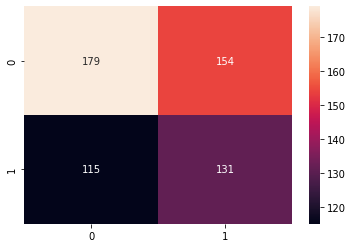

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(clf.predict(X_test_scaled), y_test)
f = sns.heatmap(cm, annot=True, fmt='d')

In [22]:
rest_df = pd.read_csv('bitcoin_df.csv')[['date', 'btc_subjectivity', 'btc_label', 'btc_score', 'cpi', 'fed']]
rest_df.date = pd.to_datetime(rest_df.date)
df = pd.merge(df, rest_df, how='left', on='date')
df.iloc[90, 26] = 0
df.iloc[90, 27] = 0
df.iloc[90, 28] = 0
df.iloc[90, 29] = 1.73
df.iloc[90, 30] = 0.11
X_ = df.drop(['date', 'btc_return'], axis=1)
# X_ = df.drop(['date', 'ltc_return'], axis=1)

In [23]:
df.shape

(2894, 31)

In [24]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y, test_size=val_size, shuffle=False)
X_train_scaled_ = scaler.fit_transform(X_train_)
X_test_scaled_ = scaler.transform(X_test_)

In [25]:
clf2 = MLPClassifier(random_state=22, max_iter=1000).fit(X_train_scaled_, y_train)

In [26]:
# clf2.predict(X_test_scaled_)
# clf2.score(X_test_scaled_,y_test)

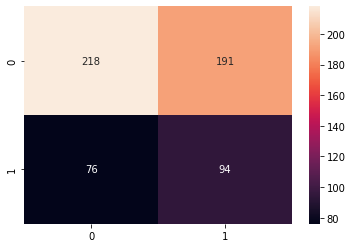

In [27]:
cm = confusion_matrix(clf2.predict(X_test_scaled_), y_test)
f = sns.heatmap(cm, annot=True, fmt='d')

In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50, 100, 50), (100,)],
    'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.005, 0.001],
    'learning_rate': ['constant','adaptive'],
}

In [30]:
clf2_tuned = GridSearchCV(MLPClassifier(random_state=42, max_iter=1000), parameter_space, n_jobs=-1, cv=5)
clf2_tuned.fit(X_train_scaled_, y_train)
clf2_tuned.score(X_test_scaled_, y_test)

0.48704663212435234

In [31]:
clf2_tuned.best_params_

{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'solver': 'sgd'}

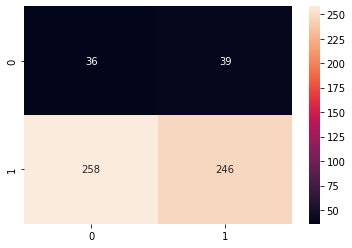

In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_pred = clf2_tuned.predict(X_test_scaled_)
cm = confusion_matrix(y_pred, y_test)
f = sns.heatmap(cm, annot=True, fmt='d')

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.12      0.20       294
           1       0.49      0.86      0.62       285

    accuracy                           0.49       579
   macro avg       0.48      0.49      0.41       579
weighted avg       0.48      0.49      0.41       579



LSTM

In [34]:
df.columns

Index(['date', 'btc_open', 'btc_high', 'btc_low', 'btc_close', 'btc_volume',
       'btc_stochastic_oscillator', 'btc_momentum_indicator', 'btc_CCI',
       'btc_obv', 'btc_ema', 'btc_trix', 'btc_macd', 'btc_vmap', 'btc_fi',
       'btc_bb_bbhi', 'btc_bb_bbli', 'btc_cmf', 'btc_rsi', 'btc_mfi',
       'btc_return', 'sp500_close', 'gold_close', 'ty5_close', 'ty10_close',
       'ty30_close', 'btc_subjectivity', 'btc_label', 'btc_score', 'cpi',
       'fed'],
      dtype='object')

In [35]:
# df_lstm = df.drop(['date', 'btc_return', 'ltc_return'], axis=1)
# df_lstm = df.drop(['date', 'btc_return'], axis=1)
df_lstm = df.drop(['date'], axis=1)
# btc_idx = ltc_idx = 0
btc_idx = btc_price_idx = 0
for i in range(len(df_lstm.columns)):
  if btc_idx and btc_price_idx:
    break
  if df_lstm.columns[i] == 'btc_return':
    btc_idx = i
  elif df_lstm.columns[i] == 'btc_close':
    btc_price_idx = i
  # elif df_lstm.columns[i] == 'ltc_close':
  #   ltc_idx = i
idx_order = [btc_idx, btc_price_idx] + [i for i in range(len(df_lstm.columns)) if i != btc_idx and i != btc_price_idx]
df_lstm = df_lstm.iloc[:, idx_order]
btc_test_price = list(df_lstm.iloc[:,1].to_list()[len(X_train)+21:])

In [36]:
df_lstm_train = scaler.fit_transform(df_lstm[:len(X_train)])
df_lstm_test = scaler.transform(df_lstm[len(X_train):])
X_train_lstm = []
y_train_lstm = []
n_future = 1
n_past = 21
for i in range(n_past,len(X_train)):
    X_train_lstm.append(df_lstm_train[i - n_past:i,:]) 
    y_train_lstm.append(df_lstm_train[i + n_future - 1:i + n_future, 0]) 
y_train_lstm = np.array(y_train_lstm)
X_train_lstm = np.array(X_train_lstm)

X_test_lstm = []
y_test_lstm = []

for i in range(n_past,len(X_test)-n_future+1):
    X_test_lstm.append(df_lstm_test[i - n_past:i,:]) 
    y_test_lstm.append(df_lstm_test[i + n_future - 1:i + n_future, 0])
y_test_lstm = np.array(y_test_lstm)
X_test_lstm = np.array(X_test_lstm)

In [37]:
X_test_lstm.shape

(558, 21, 30)

In [38]:
y_train_lstm

array([[0.],
       [1.],
       [1.],
       ...,
       [0.],
       [1.],
       [0.]])

---------------------------------------------
simulation number: 1/1 seed number: 5858
Epoch 1/100
36/36 [==============================] - 7s 38ms/step - loss: 0.6893 - binary_accuracy: 0.5488
Epoch 2/100
36/36 [==============================] - 1s 38ms/step - loss: 0.6870 - binary_accuracy: 0.5488
Epoch 3/100
36/36 [==============================] - 1s 40ms/step - loss: 0.6867 - binary_accuracy: 0.5488
Epoch 4/100
36/36 [==============================] - 1s 41ms/step - loss: 0.6882 - binary_accuracy: 0.5484
Epoch 5/100
36/36 [==============================] - 2s 42ms/step - loss: 0.6866 - binary_accuracy: 0.5488
Epoch 6/100
36/36 [==============================] - 1s 40ms/step - loss: 0.6866 - binary_accuracy: 0.5488
Epoch 7/100
36/36 [==============================] - 1s 42ms/step - loss: 0.6871 - binary_accuracy: 0.5488
Epoch 8/100
36/36 [==============================] - 2s 42ms/step - loss: 0.6868 - binary_accuracy: 0.5501
Epoch 9/100
36/36 [==============================] - 2s 4

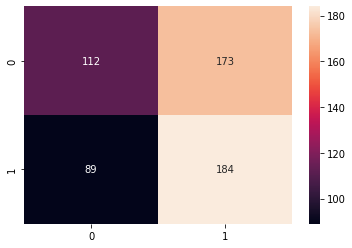

In [39]:
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras import optimizers
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
from collections import Counter

#relu: 8527 
#relu w batchnormalization: 3691 
#tanh w: 6747
#PReLU w: 6528 3235 8146
#gelu w: 9934 1806
#gelu: 1467 934 8786 1957 4790 6675
#selu: 7224

def simulation(seed_num):
  def create_LSTM(lookback, feature_dim, seed_num):
      tensorflow.random.set_seed(seed_num)
      model = keras.Sequential()
      model.add(LSTM(64, activation='gelu', input_shape = (lookback, feature_dim), return_sequences=True))
      model.add(Dropout(0.2))
      #model.add(BatchNormalization())
      model.add(LSTM(32, activation='gelu'))
      model.add(Dropout(0.2))
      #model.add(BatchNormalization())
      model.add(Dense(1, activation="sigmoid"))
      model.compile(loss="binary_crossentropy"
                    ,metrics=[keras.metrics.binary_accuracy]
                    ,optimizer="adam")
      return model

  # path_checkpoint = "model_checkpoint.h1"
  #es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=15)

  # modelckpt_callback = keras.callbacks.ModelCheckpoint(
  #     monitor="val_loss",
  #     filepath=path_checkpoint,
  #     verbose=1,
  #     save_weights_only=True,
  #     save_best_only=True,
  # )

  LSTM_model = create_LSTM(X_train_lstm.shape[1], X_train_lstm.shape[2], seed_num)
  LSTM_model.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=64)
  LSTM_pred = LSTM_model.predict(X_test_lstm)
  LSTM_pred = np.where(LSTM_pred > 0.5, 1, 0)
  test_sample.append(LSTM_pred)
  #print(LSTM_pred)
  # LSTM_pred = LSTM_pred.reshape(LSTM_pred.shape[0], LSTM_pred.shape[1])
  # inv_yhat = np.concatenate((LSTM_pred, df_lstm[len(X_train):].iloc[n_past:, 1:]), axis=1)
  # inv_yhat = scaler.inverse_transform(inv_yhat)
  # inv_yhat = inv_yhat[:,0]
  # inv_y = df_lstm[len(X_train):].iloc[n_past:, 0].to_list()

  # plt.plot(inv_y)
  # plt.plot(inv_yhat);

  # actual_return = []
  # pred_return = []
  # for i in range(len(inv_y)-1):
  #     if inv_y[i+1] > inv_y[i]:
  #       actual_return.append(1)
  #     else:
  #       actual_return.append(0)
  #     if inv_yhat[i+1] > inv_yhat[i]:
  #       pred_return.append(1)
  #     else:
  #       pred_return.append(0)

  cm = confusion_matrix(y_test_lstm, LSTM_pred)
  f = sns.heatmap(cm, annot=True, fmt='d')
  print(classification_report(y_test_lstm, LSTM_pred))
  print(Counter(LSTM_pred.flatten()))
  sim_results.append(classification_report(y_test_lstm, LSTM_pred, output_dict=True)['accuracy'])


sim_arr = np.random.choice([i for i in range(10000)], 1, replace=False)
sim_results = []
test_sample = []
for i in range(len(sim_arr)):
  print("---------------------------------------------")
  print("simulation number: " + str(i+1) + "/" + str(len(sim_arr)) + " seed number: "+str(sim_arr[i]))
  simulation(sim_arr[i])
print(sim_results)
print(np.mean(sim_results))

In [40]:
from tensorflow.keras.layers import Input
#934 333
class MyHyperModel(kt.HyperModel):
  def build(self, hp):
      tensorflow.random.set_seed(42)
      model = Sequential()
      model.add(Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
      hp_units = hp.Int('units', min_value=32, max_value=128, step=32)
      model.add(LSTM(units=hp_units, activation='gelu', return_sequences=True))
      model.add(Dropout(0.2))
      # model.add(LSTM(units=hp_units, activation='relu', return_sequences=True))
      # model.add(Dropout(0.2))
      model.add(LSTM(units=hp_units, activation='gelu'))
      model.add(Dropout(0.2))
      model.add(Dense(1, activation = 'sigmoid'))
      # Tune the Learning rate for the optimizer
      # Choose an optimal value 
      hp_learning_rate = hp.Choice('learning_rate', values=[0.005, 1e-3, 1e-4, 1e-5])
      model.compile(optimizer = Adam(learning_rate=hp_learning_rate),
                    loss = 'binary_crossentropy',
                    metrics = [keras.metrics.binary_accuracy])
      return model

  def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [16, 32]),
            **kwargs,
        )

tuner = kt.Hyperband(MyHyperModel(), # the hypermodel
                     objective='loss', # objective to optimize
                     max_epochs=100,
                     directory='dir', # directory to save Logs
                     project_name= 'khyperband')
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.005, 'conditions': [], 'values': [0.005, 0.001, 0.0001, 1e-05], 'ordered': True}


In [41]:
tuner.search(X_train_lstm, y_train_lstm, epochs=100)

Trial 30 Complete [00h 00m 16s]
loss: 0.6891278624534607

Best loss So Far: 0.6882159113883972
Total elapsed time: 00h 07m 15s
INFO:tensorflow:Oracle triggered exit


In [42]:
best_hps=tuner.get_best_hyperparameters()[0]
h_model = tuner.hypermodel.build(best_hps)
h_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 21, 32)            8064      
                                                                 
 dropout_2 (Dropout)         (None, 21, 32)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 16417 (64.13 KB)
Trainable params: 16417 (64.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
h_model.fit(X_train_lstm, y_train_lstm, epochs=100)
LSTM_h_pred = h_model.predict(X_test_lstm)
LSTM_h_pred = np.where(LSTM_h_pred > 0.5, 1, 0)

Epoch 1/100
72/72 [==============================] - 8s 27ms/step - loss: 0.6905 - binary_accuracy: 0.5480
Epoch 2/100
72/72 [==============================] - 2s 30ms/step - loss: 0.6885 - binary_accuracy: 0.5488
Epoch 3/100
72/72 [==============================] - 2s 33ms/step - loss: 0.6872 - binary_accuracy: 0.5488
Epoch 4/100
72/72 [==============================] - 2s 33ms/step - loss: 0.6874 - binary_accuracy: 0.5488
Epoch 5/100
72/72 [==============================] - 2s 32ms/step - loss: 0.6870 - binary_accuracy: 0.5493
Epoch 6/100
72/72 [==============================] - 2s 32ms/step - loss: 0.6884 - binary_accuracy: 0.5506
Epoch 7/100
72/72 [==============================] - 2s 33ms/step - loss: 0.6862 - binary_accuracy: 0.5493
Epoch 8/100
72/72 [==============================] - 2s 32ms/step - loss: 0.6866 - binary_accuracy: 0.5484
Epoch 9/100
72/72 [==============================] - 3s 37ms/step - loss: 0.6867 - binary_accuracy: 0.5436
Epoch 10/100
72/72 [=================

              precision    recall  f1-score   support

           0       0.32      0.59      0.42       155
           1       0.77      0.52      0.62       403

    accuracy                           0.54       558
   macro avg       0.55      0.56      0.52       558
weighted avg       0.65      0.54      0.56       558



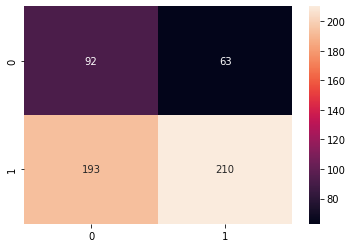

In [44]:
cm = confusion_matrix(LSTM_h_pred, y_test_lstm)
f = sns.heatmap(cm, annot=True, fmt='d')
print(classification_report(LSTM_h_pred, y_test_lstm))

In [45]:
bt_df = pd.DataFrame([btc_test_price, LSTM_h_pred.flatten(), y_test_lstm.flatten()]).T
bt_df.columns = ['btc_price', 'pred', 'actual']

In [46]:
bt_df

,btc_price,pred,actual
0,54738.945313,1.0,0.0
1,52774.265625,1.0,0.0
2,51704.160156,1.0,1.0
3,55137.312500,1.0,1.0
4,55973.511719,1.0,0.0
...,...,...,...
553,19110.546875,0.0,1.0
554,19426.720703,0.0,1.0
555,19573.050781,0.0,0.0
556,19431.789063,0.0,0.0


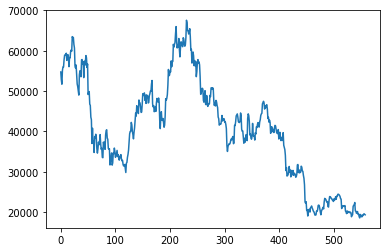

In [47]:
plt.plot(bt_df.btc_price);

In [48]:
def max10_strategy(df,cash,new_df,commission,initial_margin,maintenance_margin,interest):
    #for deciding initial positions of buy and hold strategy
    initial=cash
    crypto = 0
    position = 0
    cash_base_level = 5000
    signal = ''
    margin_account = []
    lose_all = False
    for i in range(len(df)):
        #for long position, adjust price movements
        if i > 0 and position > 0:
            diff = df.btc_price[i] - df.btc_price[i-1]
            crypto += position * diff
        #check if each margin account (if any) satisfy the margin requirement
        if i > 0 and position < 0:
            diff = df.btc_price[i-1] - df.btc_price[i]
            for j in range(len(margin_account)):
                margin_account[j][0] += diff
                margin_account[j][-1] += margin_account[j][1]*interest
                amount, maintenance = margin_account[j][0], margin_account[j][2]
                if amount < maintenance: 
                    if cash > (maintenance - amount): #amount less than maintenance margin
                        cash -= (maintenance - amount)
                        margin_account[j][0] = maintenance
                    else: #lose all the money
                        print('lose all')
                        lose_all = True
                        break
        if lose_all:
           break
        #reaching 10
        if(position>=10):
            signal="close and sell all "
            cash+=position*df.btc_price[i]*(1-commission)
            position=0
            crypto=0
        #reaching -10
        elif(position<=-10):
            signal="close and buy all"
            cash+= sum(e[0]-e[-1] for e in margin_account)
            position=0
            margin_account.clear()
        else:
            #indicate signal and buyin/selling amount
            signal="no action"
            pos=1 if df.pred[i]==1 else -1
            #money and coin value
            if pos == 1:
              if position >= 0:
                  if cash - pos*df.btc_price[i]*(1+commission) >= cash_base_level: #enough cash to buy coins
                      signal = 'buy'
                      cash-=pos*df.btc_price[i]*(1+commission)
                      position+=pos
                      crypto+=pos*df.btc_price[i]
              else:
                  signal = 'buy to close half'
                  n = abs(position)//2
                  for _ in range(max(1,n)):
                    removed = margin_account.pop(0)
                    cash += removed[0]-removed[-1]
                    position += pos
            elif pos == -1:
                if position <= 0:
                   if cash - abs(pos)*df.btc_price[i]*initial_margin >= cash_base_level:
                      signal = 'short sell'
                      for _ in range(abs(pos)):
                          margin_account.append([df.btc_price[i]*initial_margin, df.btc_price[i]*initial_margin, df.btc_price[i]*maintenance_margin, 0]) 
                          cash -= df.btc_price[i]*initial_margin
                      position += pos
                else:
                   signal = 'sell half'
                   n = position//2
                   for _ in range(max(1,n)): 
                      cash += df.btc_price[i]*(1-commission)
                      crypto -= df.btc_price[i]
                      position += pos
        dic={
            "signal":signal,
            "strategy value":cash+crypto+sum(e[0]-e[-1] for e in margin_account),
            "position":position,
            "buy and hold":(initial/df.btc_price[0])*df.btc_price[i]
        }
        new_df.append(dic)

        # print('index ' + str(i))
        # print('pos: '+ str(pos) + ' ' + signal+ ' at '+str(df.btc_price[i]))
        # print('position: '+str(position))
        # print('cash: '+str(cash))
        # print('crypto: '+str(crypto))
        # print(margin_account)
        # print('total: '+str(cash+crypto+sum(e[0]-e[-1] for e in margin_account)))
        # print('------')
    df2 = pd.DataFrame(new_df)
    
    return df2

In [49]:
max10_df = max10_strategy(bt_df,100000,[],0.002,0.5,0.3,0.0002)

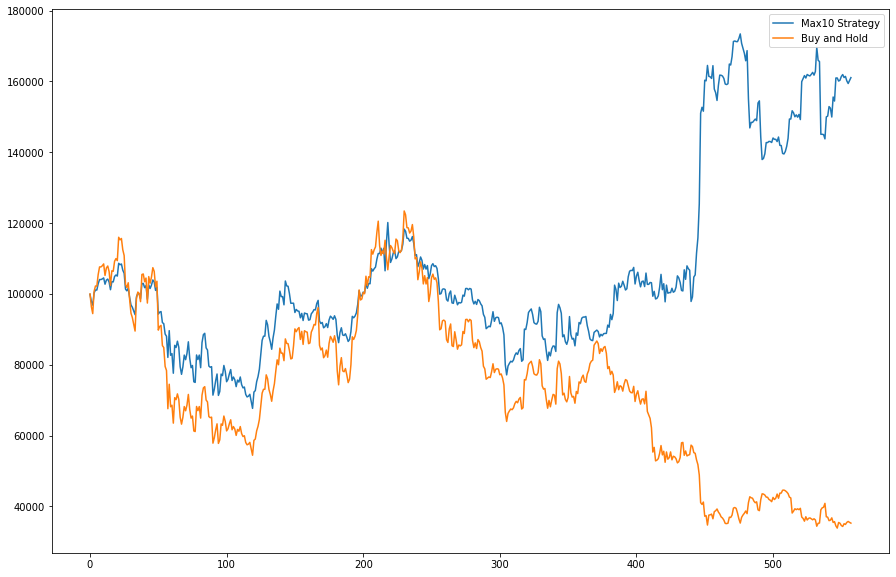

In [50]:
max10_df

plt.figure(figsize=(15,10))
plt.plot(max10_df["strategy value"], label='Max10 Strategy')
plt.plot(max10_df["buy and hold"], label='Buy and Hold')
plt.legend()
plt.show();

In [51]:
def momentum_strategy(df,cash,new_df,commission,initial_margin,maintenance_margin, interest):
    #for deciding initial positions of buy and hold strategy
    initial=cash
    crypto = 0
    position = 0
    cash_base_level = 5000
    signal = ''
    margin_account = []
    lose_all = False
    for i in range(len(df)):
        #for long position, adjust price movements
        if i > 0 and position > 0:
            diff = df.btc_price[i] - df.btc_price[i-1]
            crypto += position * diff
        #check if each margin account (if any) satisfy the margin requirement
        if i > 0 and position < 0:
            diff = df.btc_price[i-1] - df.btc_price[i]
            for j in range(len(margin_account)):
                margin_account[j][0] += diff
                margin_account[j][-1] += margin_account[j][1]*interest
                amount, maintenance = margin_account[j][0], margin_account[j][2]
                if amount < maintenance: 
                    if cash > (maintenance - amount): #amount less than maintenance margin
                        cash -= (maintenance - amount)
                        margin_account[j][0] = maintenance
                    else: #lose all the money
                        print('lose all')
                        lose_all = True
                        break
        signal = 'no action'
        if lose_all:
           break

        if df.pred[i] == 1:
            if not position and cash - df.btc_price[i]*(1+commission) >= cash_base_level: #position is 0, buy 1 coin
                signal = 'buy' 
                cash-=df.btc_price[i]*(1+commission)
                crypto+=df.btc_price[i]
                position+=1
            elif position > 0 and cash - df.btc_price[i]*(1+commission) >= cash_base_level: #if position > 0 and bitcoin price has been growing for the past 4 days, we think there is momentum and buy more
                if sum(df.actual[i-4:i].to_list()) == 4:
                  signal = 'buy more'
                  cash-=df.btc_price[i]*(1+commission)
                  crypto+=df.btc_price[i]
                  position+=1
            elif position < 0:
                signal="close and buy all"
                cash+= sum(e[0] - e[-1] for e in margin_account)
                position=0
                margin_account.clear()
        else:
            if not position and cash - df.btc_price[i]*initial_margin >= cash_base_level:
                signal = 'short sell'
                cash -= df.btc_price[i]*initial_margin
                margin_account.append([df.btc_price[i]*initial_margin, df.btc_price[i]*initial_margin, df.btc_price[i]*maintenance_margin, 0])
                position -= 1
            elif position < 0 and cash - df.btc_price[i]*initial_margin >= cash_base_level:
                if sum(df.actual[i-4:i].to_list()) == -4:
                    signal = 'sell more'
                    margin_account.append([df.btc_price[i]*initial_margin, df.btc_price[i]*initial_margin, df.btc_price[i]*maintenance_margin, 0])
                    position -= 1
            elif position > 0:
                signal = "close and sell all"
                cash+=crypto*(1-commission)
                position=0
                crypto=0
        dic={
            "signal":signal,
            "strategy value":cash+crypto+sum(e[0]-e[-1] for e in margin_account),
            "position":position,
            "buy and hold":(initial/df.btc_price[0])*df.btc_price[i]
        }
        new_df.append(dic)

        # print('index ' + str(i))
        # print('direction: '+ str(int(df.pred[i])) + ', ' + signal+ ' at '+str(df.btc_price[i]))
        # print('position: '+str(position))
        # print('cash: '+str(cash))
        # print('crypto: '+str(crypto))
        # print(margin_account)
        # print('total: '+str(cash+crypto+sum(e[0] - e[-1] for e in margin_account)))
        # print('------')
    df2 = pd.DataFrame(new_df)
   
    return df2

In [52]:
momentum_df = momentum_strategy(bt_df,100000,[],0.002,0.5,0.3,0.0002)

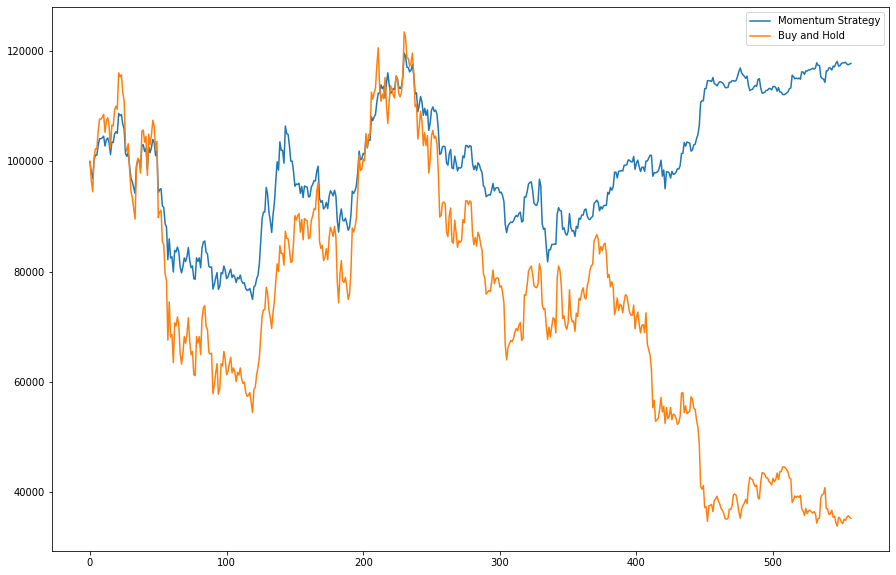

In [53]:
momentum_df

plt.figure(figsize=(15,10))
plt.plot(momentum_df["strategy value"], label='Momentum Strategy')
plt.plot(momentum_df["buy and hold"], label='Buy and Hold')
plt.legend()
plt.show();